In [1]:
%load_ext autoreload

In [21]:
%autoreload 2
import cmath
from datetime import datetime
from matplotlib import colors
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable
from neural_analysis.matIO import loadmat
from neural_analysis import spectra
from nolitsa import delay
import numpy as np
import os
import pandas as pd
import re
import scipy
from scipy.signal import butter, lfilter
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from statsmodels.stats.diagnostic import acorr_ljungbox, het_arch
from statsmodels.tsa.api import AutoReg, VAR
import sys
import time
from tqdm.auto import tqdm
import traceback as tb

plt.style.use('../../sci_style.py')

sys.path.append('../../..')
from iaaft import surrogates
from dynamical_systems_models import construct_dictionary, perform_stability_analysis, get_stability_results, compute_EDMD, predict_EDMD, compute_VAR_p, predict_VAR_p
from nld_utils import calculate_fnn_stat, embed_signal, get_nn_indices
from plot import plot_individual_areas, plot_multipopulation
from up_down import get_up_down
from utils import compute_summary_statistics, get_data_class, get_result_path, load, load_session_data, run_window_selection, save

# Load Neural Data 

In [3]:
session = 'Mary-Anesthesia-20160912-02'

In [4]:
all_data_dir = '/om/user/eisenaj/datasets/anesthesia/mat'
data_class = get_data_class(session, all_data_dir)

In [5]:
variables = ['electrodeInfo', 'lfp', 'lfpSchema', 'sessionInfo', 'spikeTimes', 'unitInfo']
session_vars, T, N, dt = load_session_data(session, all_data_dir, variables, data_class=data_class, verbose=False)
electrode_info, lfp, lfp_schema, session_info, spike_times, unit_info = session_vars['electrodeInfo'], session_vars['lfp'], session_vars['lfpSchema'], session_vars['sessionInfo'], session_vars['spikeTimes'], session_vars['unitInfo']

In [6]:
spike_times = spike_times[0]

# Get Signals

In [7]:
session_info['drugStart']/60

array([19.25317778, 49.25317778])

In [89]:
window = 5000 # ms 
start_time1 = 4000 # ms
start_time2 = 55*60*1000 # ms
indices = np.where(electrode_info['area'] == 'vlPFC')[0]

signal_in_wake = lfp[start_time1:window + start_time1, indices]
signal_in_anesthesia = lfp[start_time2:window + start_time2, indices]

# pca = PCA(n_components = 10)
# signal_in_wake = pca.fit_transform(signal_in_wake)
# signal_in_anesthesia = pca.fit_transform(signal_in_anesthesia)

# Radial Basis Functions

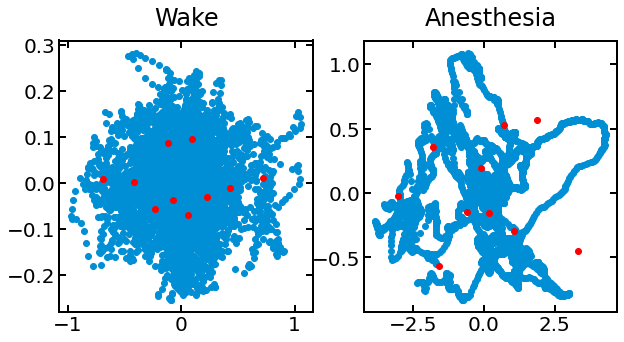

In [57]:
dim = 2
num_clusters = 10
pca = PCA(n_components = dim)

if dim == 2:
    projection = 'rectilinear'
else:
    projection = '3d'
ax1 = plt.subplot(1, 2, 1, projection=projection)
ax2 = plt.subplot(1, 2, 2, projection=projection)

X_pca = pca.fit_transform(signal_in_wake)
kmeans = KMeans(n_clusters=num_clusters)
kmeans_fit = kmeans.fit(signal_in_wake)
cluster_centers = kmeans_fit.cluster_centers_
cc_pca = pca.fit_transform(cluster_centers)
if dim == 2:
    ax1.scatter(X_pca[:, 0], X_pca[:, 1])
    ax1.scatter(cc_pca[:, 0], cc_pca[:, 1], c='r')
else:
    ax1.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2])
    ax1.scatter(cc_pca[:, 0], cc_pca[:, 1], cc_pca[:, 2], c='r')

ax1.set_title('Wake')

X_pca = pca.fit_transform(signal_in_anesthesia)
kmeans = KMeans(n_clusters=num_clusters)
kmeans_fit = kmeans.fit(signal_in_anesthesia)
cluster_centers = kmeans_fit.cluster_centers_
cc_pca = pca.fit_transform(cluster_centers)
if dim == 2:
    ax2.scatter(X_pca[:, 0], X_pca[:, 1])
    ax2.scatter(cc_pca[:, 0], cc_pca[:, 1], c='r')
else:
    ax2.scatter(X_pca[:, 0], X_pca[:, 1], X_pca[:, 2])
    ax2.scatter(cc_pca[:, 0], cc_pca[:, 1], cc_pca[:, 2], c='r')
ax2.set_title('Anesthesia')

plt.show()

In [63]:
signal_in = signal_in_anesthesia
num_cluster_vals = [11, 12, 13, 15, 18, 20, 25, 30, 40, 50, 60, 75, 90, 100]
interpolation_mse = []
for num_clusters in tqdm(num_cluster_vals):
    kmeans = KMeans(n_clusters=num_clusters)
    kmeans_fit = kmeans.fit(signal_in_anesthesia)
    cluster_centers = kmeans_fit.cluster_centers_
    rbf_int = scipy.interpolate.RBFInterpolator(cluster_centers, cluster_centers, kernel='thin_plate_spline')
    X_d = rbf_int(signal_in_anesthesia)
    interpolation_mse.append(((X_d - signal_in_anesthesia)**2).mean())

  0%|          | 0/14 [00:00<?, ?it/s]

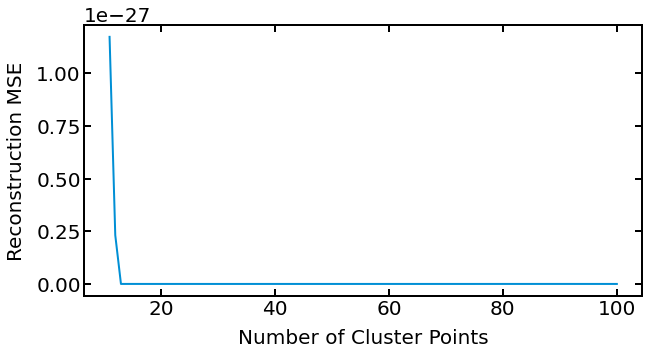

In [64]:
plt.plot(num_cluster_vals, interpolation_mse)
plt.xlabel('Number of Cluster Points')
plt.ylabel('Reconstruction MSE')
plt.show()

In [67]:
# Let's construct the basis functions

In [115]:
%%time
method = 'thin_plate_spline'
n_clusters = 500
include_signal = True

wake_d = construct_dictionary(signal_in_wake, method=method, n_clusters=n_clusters, include_signal=include_signal)

CPU times: user 11.9 s, sys: 263 ms, total: 12.2 s
Wall time: 6.36 s


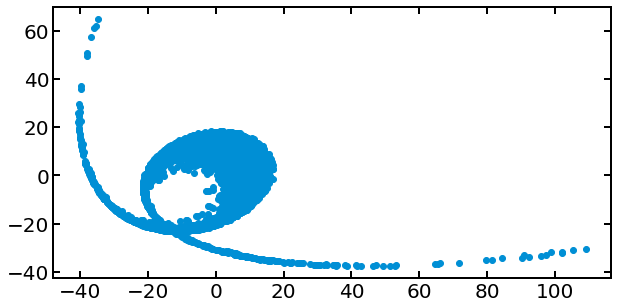

In [116]:
dict_d = pca.fit_transform(wake_d)
plt.scatter(dict_d[:, 0], dict_d[:, 1])

# EDMD

In [217]:
%%time
p = 8
lamb = 1.2
PCA_dim = -1
dictionary_method = 'thin_plate_spline'
n_clusters = 1500
include_signal = True
normalize = True

if include_signal:
    D = n_clusters + len(indices)
else:
    D = n_clusters

results_wake = compute_EDMD(signal_in_wake, p=p, lamb=lamb, PCA_dim=PCA_dim, dictionary_method=dictionary_method, n_clusters=n_clusters, include_signal=include_signal, normalize=normalize)
results_anesthesia = compute_EDMD(signal_in_anesthesia, p=p, lamb=lamb, PCA_dim=PCA_dim, dictionary_method=dictionary_method, n_clusters=n_clusters, include_signal=include_signal, normalize=normalize)

CPU times: user 8min 46s, sys: 7.8 s, total: 8min 54s
Wall time: 7min 5s


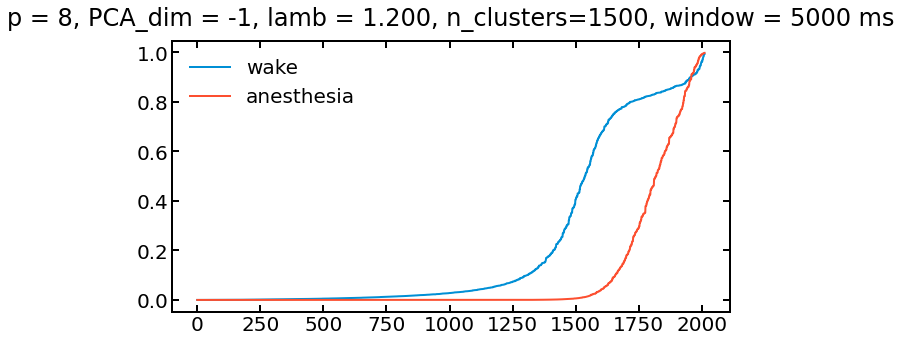

In [218]:
plt.title(f"p = {p}, PCA_dim = {PCA_dim}, lamb = {lamb:.3f}, n_clusters={n_clusters}, window = {window} ms")
plt.plot(np.sort(results_wake['criticality_inds']), label='wake')
plt.plot(np.sort(results_anesthesia['criticality_inds']), label='anesthesia')
plt.legend()
plt.show()

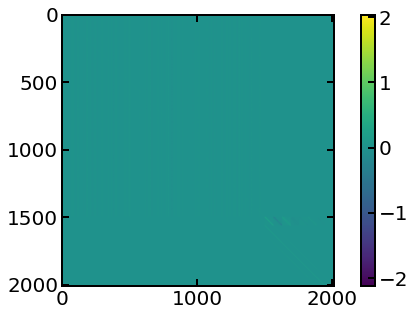

In [219]:
plt.imshow(results_wake['coefs']), plt.colorbar()
# plt.imshow(results_wake['coefs'][actual_indices, :][:, actual_indices], aspect='auto'), plt.colorbar()
# plt.imshow(results_wake['coefs'][:, actual_indices], aspect='auto'), plt.colorbar()
plt.show()

In [220]:
T_pred = 25

# test
pred_signal_wake = lfp[start_time1 + window - p:window + start_time1 + T_pred, indices]
pred_signal_anesthesia = lfp[start_time2 + window - p:window + start_time2 + T_pred, indices]

# # train
# pred_signal_wake = lfp[start_time1:window + start_time1, indices]
# pred_signal_anesthesia = lfp[start_time2:window + start_time2, indices]

In [221]:
predict_type = 'actual'
tail_bite = False
prediction = {}
true_vals = {}
pb_mse = {}
pb = {}

if D > window:
    U_wake = results_wake['U']
    U_anesthesia = results_anesthesia['U']
    predict_type = 'all'
else:
    U_wake = None
    U_anesthesia = None
prediction['wake'], true_vals['wake'], pb_mse['wake'], pb['wake'] = predict_EDMD(pred_signal_wake, results_wake['coefs'], p=p, intercept=results_wake['intercept'], U=U_wake, dictionary_method=dictionary_method, include_signal=include_signal, cluster_centers=results_wake['cluster_centers'], normalize=normalize, predict_type=predict_type, tail_bite=tail_bite, persistence_baseline=True, PCA_dim=PCA_dim)
prediction['anesthesia'], true_vals['anesthesia'], pb_mse['anesthesia'], pb['anesthesia'] = predict_EDMD(pred_signal_anesthesia, results_anesthesia['coefs'], p=p, intercept=results_anesthesia['intercept'], U=U_anesthesia, dictionary_method=dictionary_method, include_signal=include_signal, cluster_centers=results_anesthesia['cluster_centers'], normalize=normalize, predict_type=predict_type, tail_bite=tail_bite, persistence_baseline=True, PCA_dim=PCA_dim)

In [223]:
for key in ['wake', 'anesthesia']:
    print(f"{key}: pb_mse = {pb_mse[key]:.2e}, prediction mse = {((prediction[key] - true_vals[key])**2).mean():.2e}")

wake: pb_mse = 1.54e-01, prediction mse = 1.31e-01
anesthesia: pb_mse = 8.92e-02, prediction mse = 1.18e-01


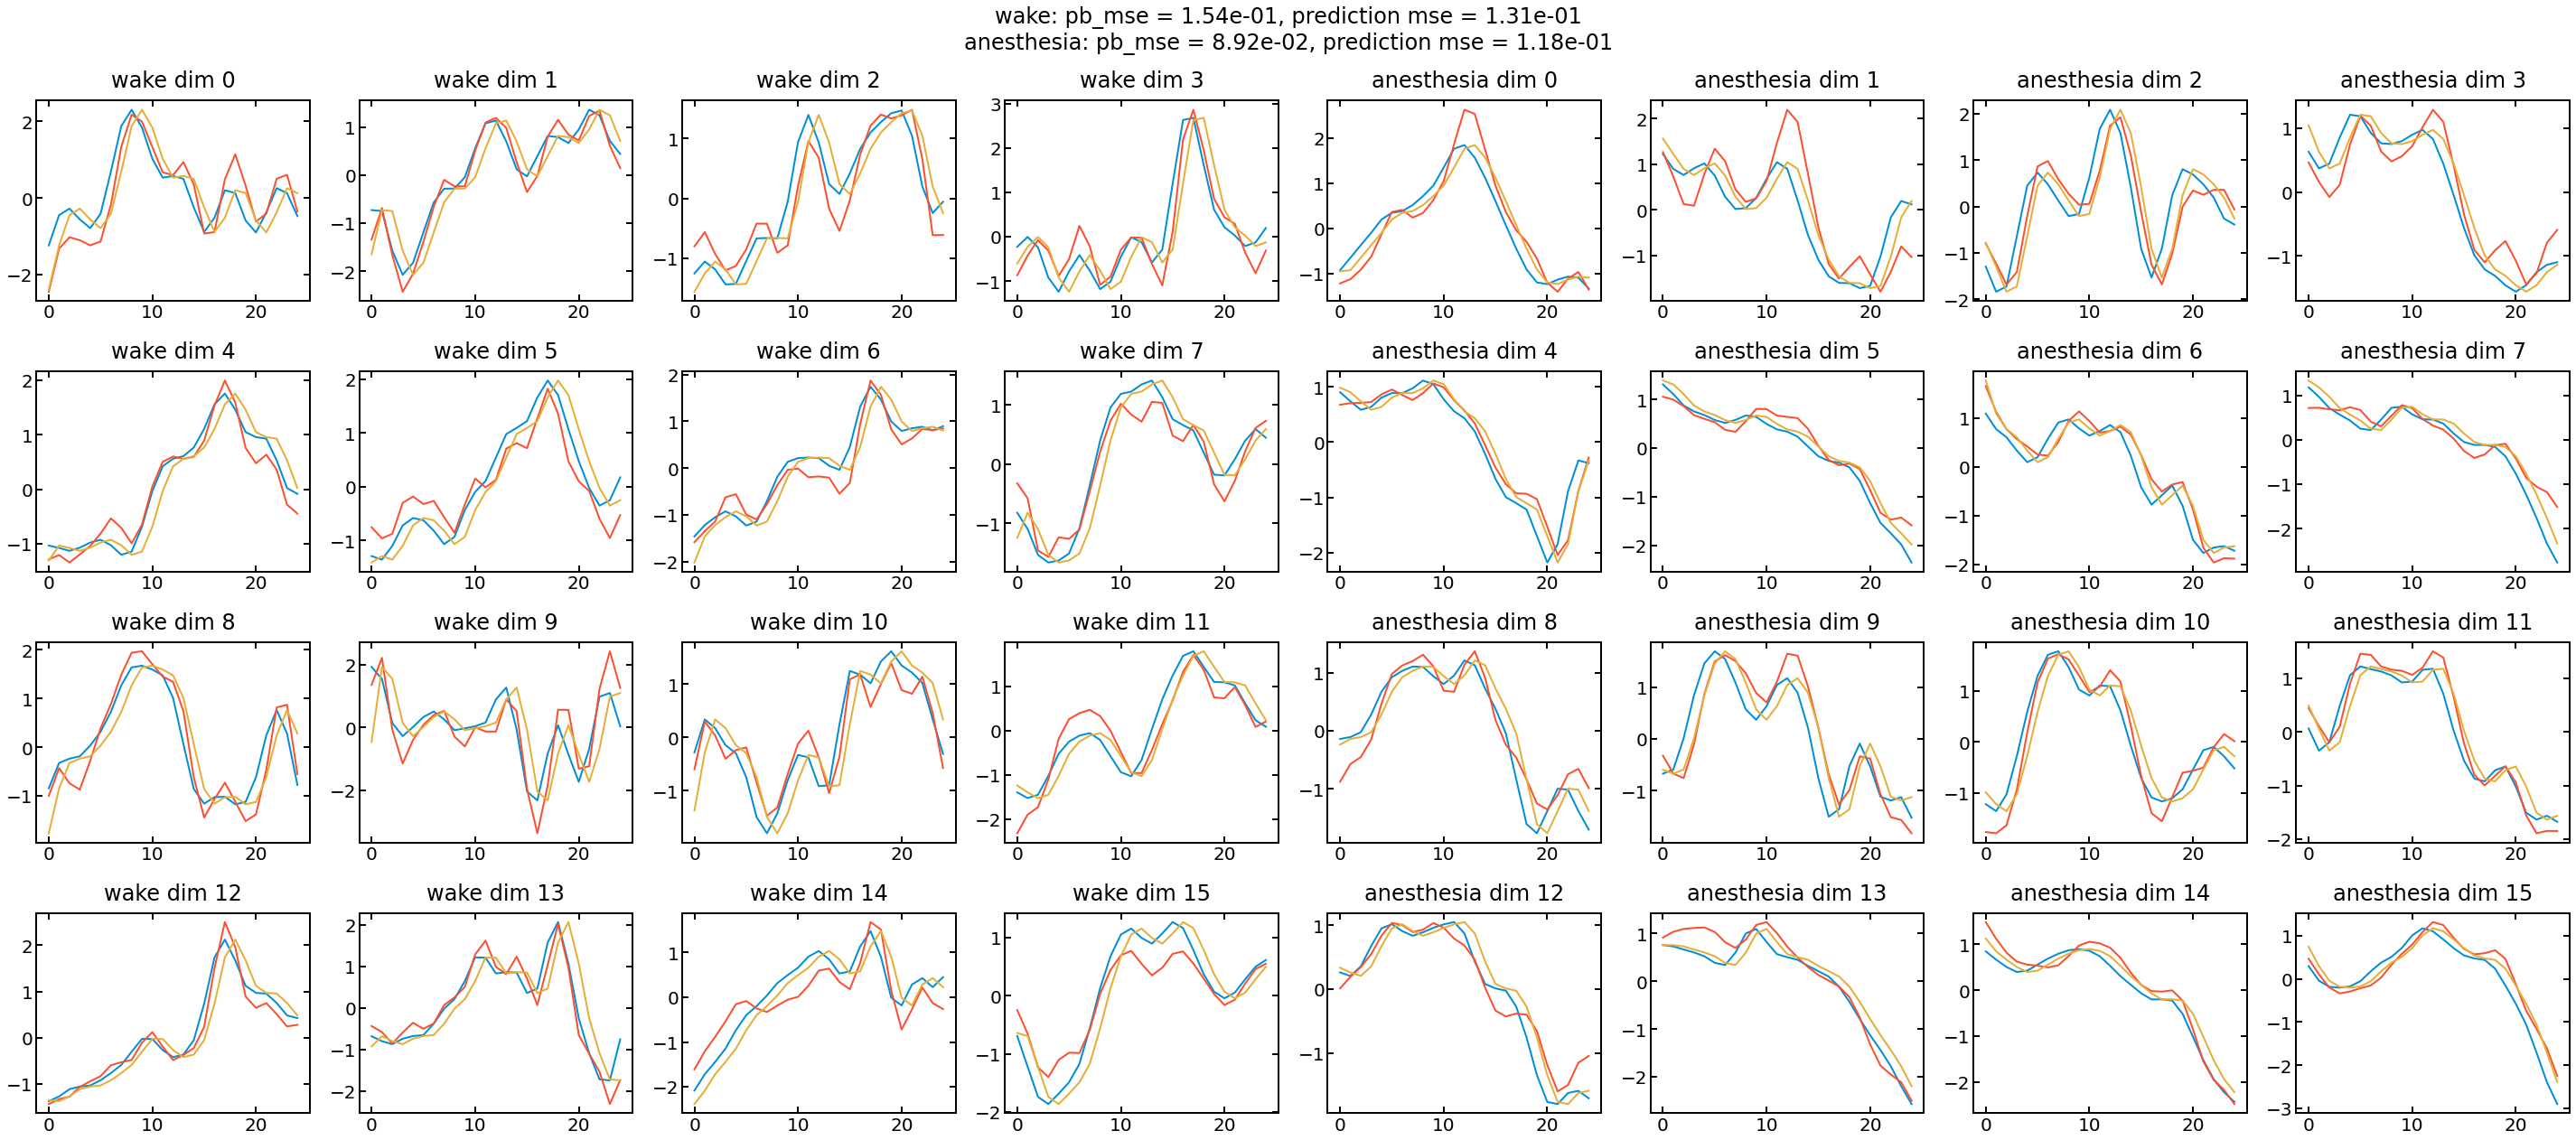

In [224]:
if predict_type == 'actual':
    rows = 4
    cols = 8
    fig, axs = plt.subplots(rows, cols, figsize=(40, 18))
else: # predict_type == 'all'
    rows = 5
    cols = 10
    fig, axs = plt.subplots(rows, cols, figsize=(40, 18))

n_plots = rows*cols

for i in range(n_plots):
    if i % cols > int(cols/2) - 1:
        key = 'anesthesia'
    else:
        key = 'wake'
    if rows == 1 or cols == 1:
        ax = axs[i]
    else:
        ax = axs[int(i/cols)][i % cols]
    
    if key == 'wake':
        dim_ind = i - int(i/cols)*int(cols/2)
    else:
        dim_ind = i - (int(i/cols) + 1)*int(cols/2)
        
    ax.plot(true_vals[key][:, dim_ind])
    ax.plot(prediction[key][:, dim_ind])
    ax.plot(pb[key][:, dim_ind])
    ax.set_title(f"{key} dim {dim_ind}")

plt.suptitle(f"wake: pb_mse = {pb_mse['wake']:.2e}, prediction mse = {((prediction['wake'] - true_vals['wake'])**2).mean():.2e}\nanesthesia: pb_mse = {pb_mse['anesthesia']:.2e}, prediction mse = {((prediction['anesthesia'] - true_vals['anesthesia'])**2).mean():.2e}")
plt.tight_layout()
plt.show()